In [1]:
import pandas as pd
import re

In [2]:
reviews = pd.read_csv("https://data.insideairbnb.com/canada/on/toronto/2024-02-14/data/reviews.csv.gz")

In [3]:
reviews.dropna(inplace=True)

In [67]:
reviews['listing_id'] = reviews['listing_id'].astype('category')
reviews['id'] = reviews['id'].astype('int')
reviews['reviewer_id'] = reviews['reviewer_id'].astype('int')
reviews['date'] = pd.to_datetime(reviews['date'])

In [4]:
# CHECK IF ENCODING NORMALIZATION NEEDED

!pip install chardet
import chardet

# Convert the 'comments' column to bytes, then detect encoding
byte_data = reviews['comments'].astype(str).apply(lambda x: x.encode('utf-8'))
encodings = byte_data.apply(lambda x: chardet.detect(x))

# Show detected encodings
print(encodings.apply(lambda x: x['encoding']).value_counts())

comments
ascii           397551
utf-8            57202
Windows-1252     47638
Windows-1254      4739
ISO-8859-1        2936
ISO-8859-9        1914
EUC-KR              43
GB2312              36
TIS-620             25
EUC-JP               9
IBM855               4
IBM866               3
Big5                 2
windows-1253         1
Name: count, dtype: int64


What we see above with the various encodings is not uncommon, especially in datasets that aggregate text data from multiple sources or user inputs.

Multiple Encodings in Text Data

Diverse Sources: If your data comes from various sources (websites, user inputs, different systems), each source might use a different encoding standard. For instance, web pages from different countries or older databases might use different encodings
.
Historical Reasons: Some older systems or regional systems use specific encodings like Windows-1252 or ISO-8859-1 for compatibility reasons. These might persist in data that hasn't been uniformly updated or standardize
d.
User-Generated Content: When users submit data from different devices or locations, the encoding can depend on the default settings of their systems, which can vary wide
ly.
Software and Platform Variations: Different software and platforms handle text encoding differently. For example, some might default to UTF-8, while others might use ASCII or a Windows-specific encoding depending on the system setti


In order to handle multiple encodings, we will normalize these encodings (convert encodings) into a single standard.
We will use 'UTF-8', despite the majority being ASCII, as it is considered best practice for several reasons:
- it is compatible with ASCII
- universal character support
- web and internet standards - uft-8 is the dominant character encoding for the web and is reccomended by internet protocols and standards
- efficiency and storage
- future-proofing data handling
- reducing complexity in text data

Encoding coversion is about changing how text is encoded at a byte level, which doesn't necessairly alter the visual or semantic representation of the text.ngs.

In [5]:
# CHECK IF UNICODE NORMALIZATION NEEDED

# Check frequency of non-ASCII characters
def count_non_ascii(text):
    return sum(1 for char in text if ord(char) >= 128)

reviews['non_ascii_count'] = reviews['comments'].apply(count_non_ascii)
print("Total non-ASCII characters:", reviews['non_ascii_count'].sum())

Total non-ASCII characters: 744870


The count of 744,870 non-ASCII characters in the dataset suggets a significant presence of characters that go beyond the basic ASCII range, which includes only English letters and common punctuation. 

This is an indication that Unicode normalization might be beneficial for the dataset for several reasons:
- Standardizing character representation - high count of non-ASCII characters likely includes variety of symbols, accents, and possibly ;etters from non_latin scripts that can be represented in multiple ways (composed vs decomposed forms) - Normalization can help standardize these representations, making it easier to manage, search and analyze the text data
- Improving text preprocessing compatibility - normalization will make the text data more uniform and potentially remove invisible or confusing differences between haracters that look similar or are functionally equivalent

In [6]:
# ENCODING NORMALIZATION

def normalize_encoding(text):
    detected_encoding = chardet.detect(text.encode())['encoding']
    if detected_encoding:
        try:
            # Attempt to decode with the detected encoding
            return text.encode(detected_encoding).decode('utf-8')
        except UnicodeDecodeError:
            # If the first attempt fails, try decoding as UTF-8 directly
            try:
                return text.encode('utf-8').decode('utf-8')
            except UnicodeDecodeError:
                # If UTF-8 fails, use a more lenient error handling strategy
                return text.encode('utf-8', errors='ignore').decode('utf-8', errors='ignore')
    else:
        # If no encoding detected, handle text as UTF-8
        return text.encode('utf-8', errors='ignore').decode('utf-8', errors='ignore')


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512742 entries, 0 to 512818
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   listing_id       512742 non-null  int64 
 1   id               512742 non-null  int64 
 2   date             512742 non-null  object
 3   reviewer_id      512742 non-null  int64 
 4   reviewer_name    512742 non-null  object
 5   comments         512742 non-null  object
 6   non_ascii_count  512742 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 31.3+ MB


In [8]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,non_ascii_count
0,1419,38924112,2015-07-19,11308465,Marcela,Having the opportunity of arriving to Alexandr...,0
1,1419,44791978,2015-08-29,9580285,Marco,We have no enough words to describe how beauty...,0
2,1419,45957133,2015-09-07,38394721,Andrea,The listing was exceptional and an even better...,0
3,1419,67295154,2016-03-28,3515044,Shaun,Alexandra's home was amazing and in such a nea...,0
4,1419,177702208,2017-08-03,13987100,Kate,Beautiful home. Very comfortable and clean. Pe...,1


In [9]:
# ENCODING VERIFICATION

def check_encoding(text):
    try:
        text.encode('utf-8').decode('utf-8')
        return "UTF-8"
    except UnicodeError:
        return "Not UTF-8"

reviews['encoding_check'] = reviews['comments'].apply(check_encoding)
print(reviews[reviews['encoding_check'] != "UTF-8"])
# Drop the 'encoding_check' column from the DataFrame
reviews.drop('encoding_check', axis=1, inplace=True)

Empty DataFrame
Columns: [listing_id, id, date, reviewer_id, reviewer_name, comments, non_ascii_count, encoding_check]
Index: []


In [10]:
# UNICODE NORMALIZATION

import unicodedata


def normalize_unicode(text, form='NFKC'):
    try:
        # Normalize the text using the specified form
        normalized_text = unicodedata.normalize(form, text)
        # Optional: Check if normalization is actually necessary
        if normalized_text != text:
            print(f"Normalization changed text: {text} to {normalized_text}")
        return normalized_text
    except Exception as e:
        # Handle any exception that might occur during normalization
        print(f"Error during normalization: {e}")
        return text  # Return the original text if normalization fails

reviews['comments'] = reviews['comments'].apply(lambda x: normalize_unicode(x))

<br/>GREAT PLACE, EVEN BETTER HOST. 5 Star all around in our books.  . We appreciated Shannon and her compassion towards my friend who’s grandmother had just passed. I made this late min booking due to her grandmothers funeral. Shannon was like a host we haven’t seen before. We had a little mix up when checking in, as the address was for the Marriott ( Right across the street ).  However, Shannon was amazingly accommodating and very patient with us. She went out of her way to meet us at a restaurant to bring us the keys etc for the check in. Which we greatly appreciated as it made everything very easy from there. The suite was actually very beautiful/well kept and very clean. Also very quiet. ( Which my friend loved the most )
<br/>If you have a bad back or bad knees, the apartment is situated on the first floor, but in order to get to it one must go up around 10 steps to get thru the court yard to the house and then 5 or 6 to get to the door and then up the steps, around 20 or so to R

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Normalization changed text: Very clean… we made a walk around and very quiet place… we will return for sure! I strongly recommend! to Very clean... we made a walk around and very quiet place... we will return for sure! I strongly recommend!
Normalization changed text: Alireza’s unit definitly exceeded my expectations. Thank you to Alireza to hosting my boyfriend and I for a last minute night visit in Toronto. Alireza’s service is exceptional, from quick response times, ensuring the check in process was simple and effective, the cleanlinesses of the space, being equipped with the basic necessities (like towels, coffee, soap), accessible tv networks such as YouTube and Netflix and of course… the amazing view. The location is ideal, the key pickup/drop off location was around the corner, and the place is centered in the heart of the entertainment district, walking distance to everything! Would definitly recommend Alireza as a host and for his place! to Alireza’s unit definitly exceeded my

In [34]:
# WORD COUNT

# Step 1: Tokenize and calculate word counts - word count considering non-standard characters
reviews['word_count'] = reviews['comments'].apply(lambda x: len(re.findall(r'\b\w+\b', x)))

# Step 2: Find minimum and maximum word count
min_word_count = reviews['word_count'].min()
max_word_count = reviews['word_count'].max()

print("Minimum review length in words:", min_word_count)
print("Maximum review length in words:", max_word_count)

Minimum review length in words: 1
Maximum review length in words: 1043


In [35]:
median_length = reviews['word_count'].median()
quantiles = reviews['word_count'].quantile([0.25, 0.75])
print("Median review length:", median_length)
print("25th and 75th percentiles:", quantiles)

Median review length: 29.0
25th and 75th percentiles: 0.25    14.0
0.75    53.0
Name: word_count, dtype: float64


In [11]:
# CLEAN TEXT

import re

def clean_text(text):      
    # Remove HTML tags, specifically <br/> and others
    text = re.sub(r'<br\s*/?>', ' ', text)  # Replace <br/> with a space
    text = re.sub(r'<[^>]+>', '', text)     # Remove all other HTML tags

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove @mentions
    text = re.sub(r'@\w+', '', text)

    # Remove specific special characters (not punctuation)
    text = re.sub(r'[()<>@#$%&*]', '', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading and trailing whitespaces
    text = text.strip()

    return text

reviews['cleaned_comments'] = reviews['comments'].apply(clean_text)

In [12]:
# TEXT CLEANING VALIDATION

# Example checks for remaining HTML tags or URLs
import re

html_tags = reviews['cleaned_comments'].apply(lambda x: bool(re.search(r'<[^>]+>', x)))
urls = reviews['cleaned_comments'].apply(lambda x: bool(re.search(r'http[s]?://\S+', x)))

print("Entries with HTML tags remaining:", html_tags.sum())
print("Entries with URLs remaining:", urls.sum())

Entries with HTML tags remaining: 0
Entries with URLs remaining: 0


In [13]:
# LANGUAGE DETECTION - LANGDETECT

!pip install langdetect
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# language detection function
def detect_language(text):
    try:
        return detect(text)
    except:
        return "Error"  # Handle errors if text is too short or detection fails

# Apply the language detection to the 'cleaned_comments' column
reviews['language'] = reviews['cleaned_comments'].apply(detect_language)

# Filter only English comments
reviews=reviews[reviews['language'] == 'en']

In [14]:
# RERUN LANGUAGE DETECTION

# Rerun the detection on the filtered dataset to confirm all are English
reviews['language'] = reviews['cleaned_comments'].apply(detect_language)
reviews = reviews[reviews['language'] == 'en']

In [15]:
# SENTIMENT ANALYSIS - TEXTBLOB

from textblob import TextBlob

# Function to calculate sentiment
def sentiment_textblob(text):
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    except:
        return None

reviews['sentiment_textblob'] = reviews['cleaned_comments'].apply(sentiment_textblob)

print(reviews.head())    

   listing_id         id        date  reviewer_id reviewer_name  \
0        1419   38924112  2015-07-19     11308465       Marcela   
1        1419   44791978  2015-08-29      9580285         Marco   
2        1419   45957133  2015-09-07     38394721        Andrea   
3        1419   67295154  2016-03-28      3515044         Shaun   
4        1419  177702208  2017-08-03     13987100          Kate   

                                            comments  non_ascii_count  \
0  Having the opportunity of arriving to Alexandr...                0   
1  We have no enough words to describe how beauty...                0   
2  The listing was exceptional and an even better...                0   
3  Alexandra's home was amazing and in such a nea...                0   
4  Beautiful home. Very comfortable and clean. Pe...                1   

                                    cleaned_comments language  \
0  Having the opportunity of arriving to Alexandr...       en   
1  We have no enough words t

In [19]:
# SENTIMENT ANALYSIS - VADER

!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def sentiment_vader(text):
    # Get the polarity scores
    scores = sid.polarity_scores(text)
    # Return the compound score, which is a normalized score between -1 and 1
    return scores['compound']

# Apply the function to each comment in your DataFrame
reviews['sentiment_vader'] = reviews['cleaned_comments'].apply(sentiment_vader)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\areem\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Here I will extract the top terms in positive and negative reviews. In order to do that, we need to first classify the sentiments as either positive or negative. Then the reviews will need to br processed further in order to prepare it for text vectorization. From the text vectorization, we will extract the top terms.al.e modeling.

In [20]:
# CLASSIFY SENTIMENT - POSITIVE/NEGATIVE

# Sentiment classification function
def classify_sentiment(sentiment, pos_threshold=0.1, neg_threshold=-0.1):
    if sentiment > pos_threshold:
        return 'positive'
    elif sentiment < neg_threshold:
        return 'negative'
    else:
        return 'neutral'

# Apply the classification function
reviews['textblob_class'] = reviews['sentiment_textblob'].apply(classify_sentiment)
reviews['vader_class'] = reviews['sentiment_vader'].apply(lambda x: classify_sentiment(x, 0.05, -0.05))

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

!pip install contractions
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

   ---------------------------------------- 0.0/289.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/289.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/289.9 kB 435.7 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/289.9 kB 465.5 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/289.9 kB 521.8 kB/s eta 0:00:01
   ---------------- --------------------- 122.9/289.9 kB 514.3 kB/s eta 0:00:01
   --------------------- ---------------- 163.8/289.9 kB 577.4 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/289.9 kB 588.9 kB/s eta 0:00:01
   ----------------------------- -------- 225.3/289.9 kB 597.3 kB/s eta 0:00:01
   --------------------------------- ---- 256.0/289.9 kB 603.8 kB/s eta 0:00:01
   -------------------------------------- 289.9/289.9 kB 638.5 kB/s eta 0:00:00


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\areem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\areem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\areem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

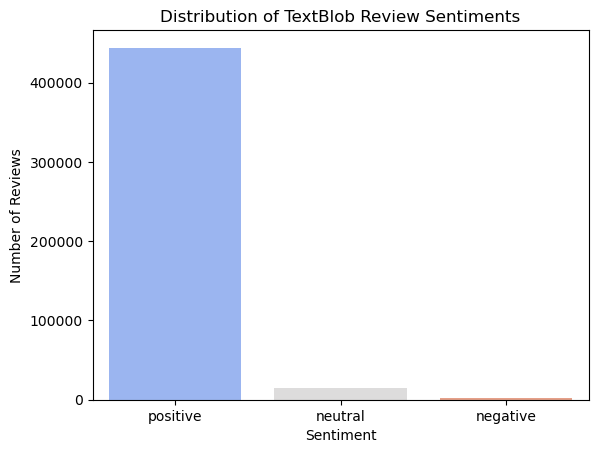

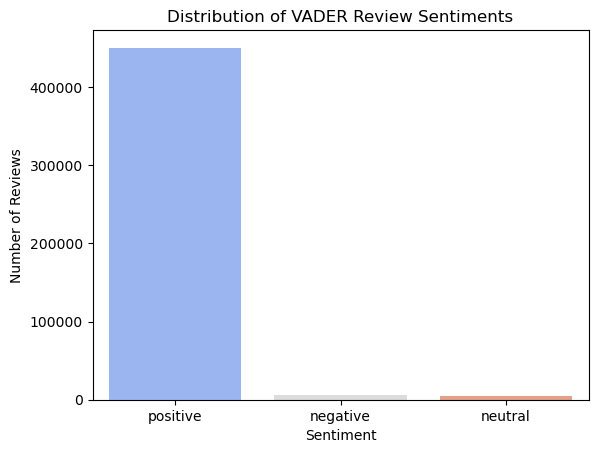

In [27]:
# Plotting the distribution of sentiments

sns.countplot(x='textblob_class', data=reviews, palette='coolwarm')
plt.title('Distribution of TextBlob Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

sns.countplot(x='vader_class', data=reviews, palette='coolwarm')
plt.title('Distribution of VADER Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [28]:
def expand_contractions(text):
    """Expand contractions in the text"""
    return contractions.fix(text)

def handle_negations(text):
    """Link words affected by negations with underscores"""
    negation_pattern = re.compile(r'\b(not|no|never|none|neither|cannot)\s+([a-zA-Z]+)')
    negated_text = negation_pattern.sub(lambda match: match.group(0).replace(' ', '_'), text)
    return negated_text

def preprocess_text(text):
    """Clean and standardize the text for NLP analysis"""
    # Expand contractions
    text = expand_contractions(text)
    # Handle negations
    text = handle_negations(text)
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\.\S+|\S+@\S+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords (conversion to set for performance optimization)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin tokens into a single string
    return ' '.join(tokens)

#Apply the preprocessing function
reviews['processed_comments'] = reviews['cleaned_comments'].apply(preprocess_text)

# Output a sample of the original and processed comments for comparison
print(reviews[['cleaned_comments', 'processed_comments']].sample(5))

                                         cleaned_comments  \
77674                Great location for downtown Toronto.   
328225  I wasn't aware from the posting that this was ...   
485134     Fabulous place! Great hosts! Would come again!   
404903  Had a great time at Grants. He was very respon...   
106485  Stefanie's place was amazing! Perfectly cozy a...   

                                       processed_comments  
77674                     great location downtown toronto  
328225  notaware posting shared least three airbnb gue...  
485134               fabulous place great host would come  
404903  great time grant responsive gave u great sugge...  
106485  stefanies place amazing perfectly cozy close p...  


Now we will apply text vectorization.

The following text vectorization techniques will be used:

CountVectorizer:
Description: Transforms the text into a matrix of token counts. It’s simple and effective for various tasks but doesn’t account for the relative importance of words.
Use Case: Good for document classification where frequency of words is predictive.

TF-IDF (Term Frequency-Inverse Document Frequency):
Description: Weighs words based on how frequently they appear in a document balanced by how often they appear across all documents. It helps in identifying which words are most descriptive in a document.
Use Case: Useful in search engines and information retrieval systems to rank the importance of words in documents.

Word2Vec:
Description: Uses a neural network model to learn word associations from a large corpus of text. Once trained, the model can detect synonymous words or suggest additional words for a partial sentence.
Use Case: Great for tasks that require capturing the context of words, such as sentiment analysis and language modeling.

BERT Embeddings (or other Transformer-based models):
Description: Based on the Transformer architecture, these models understand the context of words by processing words in relation to all other words in a sentence, rather than one-by-one in order.
Use Case: Effective for complex tasks like question answering, language inference, and other applications where understanding the context is crucial.

In [29]:
!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [55]:
from tqdm import tqdm
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

In [70]:
stop_words = set(stopwords.words('english'))

def clean(reviews):
    letters_only=BeautifulSoup(review).get_text()
    letters_only = re.sub('[^a-zA-Z0-9]', ' ', letters_only)
    letters_only = letters_only.lower()
    words= letters_only.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

all_reviews = []
for review in tqdm(reviews['processed_comments']):
    all_reviews.append(clean(review))

100%|██████████| 461317/461317 [02:07<00:00, 3620.82it/s]


Applying TF-IDF Vectorization
TF-IDF stands for Term Frequency-Inverse Document Frequency. This method weighs a term’s frequency (Term Frequency) and its inverse document frequency (Inverse Document Frequency). The idea is that terms that appear more frequently across the documents carry less meaning, thus should be weighed less.

In [75]:
tfidfvectorizer = TfidfVectorizer(analyzer='word', max_features=500)
reviews_tfidf = tfidfvectorizer.fit_transform(all_reviews)
reviews_tfidf = reviews_tfidf.toarray()

reviews_tfidf_df = pd.DataFrame(data=reviews_tfidf, 
                                columns=['tfidf_' + str(i) for i in range(500)])
reviews_tfidf_df['listing_id'] = reviews['listing_id'].astype('category')

In [76]:
# Group by listing and get average per listing

# Average the features for each listings
tfidf_features = reviews_tfidf_df.columns.difference(['listing_id'])
reviews_tfidf_avg = reviews_tfidf_df.groupby('listing_id')[tfidf_features].mean().reset_index()

print(reviews_tfidf_avg.head())

C:\Users\areem\AppData\Local\Temp\ipykernel_19688\2836304133.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviews_tfidf_avg = reviews_tfidf_df.groupby('listing_id')[tfidf_features].mean().reset_index()


   listing_id  tfidf_0   tfidf_1  tfidf_10  tfidf_100  tfidf_101  tfidf_102  \
0 -2145424723      NaN       NaN       NaN        NaN        NaN        NaN   
1 -2144992130      0.0  0.000000       0.0        0.0   0.022171        0.0   
2 -2143951892      NaN       NaN       NaN        NaN        NaN        NaN   
3 -2142742997      NaN       NaN       NaN        NaN        NaN        NaN   
4 -2141973441      0.0  0.015765       0.0        0.0   0.000000        0.0   

   tfidf_103  tfidf_104  tfidf_105  ...  tfidf_90  tfidf_91  tfidf_92  \
0        NaN        NaN        NaN  ...       NaN       NaN       NaN   
1        0.0   0.013153        0.0  ...  0.000000       0.0       0.0   
2        NaN        NaN        NaN  ...       NaN       NaN       NaN   
3        NaN        NaN        NaN  ...       NaN       NaN       NaN   
4        0.0   0.032651        0.0  ...  0.007691       0.0       0.0   

   tfidf_93  tfidf_94  tfidf_95  tfidf_96  tfidf_97  tfidf_98  tfidf_99  
0       NaN 

Applying Count Vectorization
Count Vectorization involves counting the number of times each word appears in the document. This is simpler and straightforward but doesn’t account for the popularity of a term across all documents.

In [40]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2), max_features=500)
reviews_countvec = vectorizer1.fit_transform(all_reviews)
reviews_count1= reviews_count1.toarray()

   count_0  count_1  count_2  count_3  count_4  count_5  count_6  count_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        1        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   count_8  count_9  ...  count_491  count_492  count_493  count_494  \
0        0        0  ...          0          0          0          0   
1        0        0  ...          0          0          0          0   
2        0        0  ...          1          0          1          0   
3        0        0  ...          0          0          0          0   
4        0        0  ...          0          0          0          0   

   count_495  count_496  count_497  count_498  count_499  listing_id  
0          0          0          

In [ ]:
# AGGREGA

In [ ]:
# TOP TERMS



In [ ]:
import re
# Word count

# Step 1: Tokenize and calculate word counts
# A more careful word count that considers non-standard characters
reviews['word_count'] = reviews['comments'].apply(lambda x: len(re.findall(r'\b\w+\b', x)))

# Step 2: Find minimum and maximum word count
min_word_count = reviews['word_count'].min()
max_word_count = reviews['word_count'].max()

print("Minimum review length in words:", min_word_count)
print("Maximum review length in words:", max_word_count)

In [ ]:
median_length = reviews['word_count'].median()
quantiles = reviews['word_count'].quantile([0.25, 0.75])
print("Median review length:", median_length)
print("25th and 75th percentiles:", quantiles)

In [10]:
# Filter for reviews with zero words
zero_word_reviews = reviews[reviews['word_count'] == 0]

# Check the number of zero-word reviews
print("Number of zero-word reviews:", zero_word_reviews.shape[0])

# Display some examples of zero-word reviews
print(zero_word_reviews['comments'].head())

Number of zero-word reviews: 1264
999            .
3152    👍🏽👍🏽👍🏽👍🏽
3177           💯
3180           👍
4085           .
Name: comments, dtype: object


In [11]:
zero_word_reviews['comments'].value_counts()

comments
.             657
👍             108
:)             50
-              42
...            31
             ... 
👌😂😂             1
****            1
❤️❤️❤️❤️❤️      1
✅✅              1
⭐⭐⭐⭐👍           1
Name: count, Length: 145, dtype: int64

In [12]:
# Print the top 20 most frequent zero-word comments directly
print(zero_word_reviews['comments'].value_counts().head(20))

comments
.             657
👍             108
:)             50
-              42
...            31
👍🏻             24
👌              22
..             22
👍🏾             19
⭐️⭐️⭐️⭐️⭐️     16
👍🏽             13
👍🏼             13
💯              11
👍👍             11
👍👍👍            10
❤️             10
✅               6
👌🏾              6
/               6
👍🏾👍🏾            6
Name: count, dtype: int64


In [13]:
import re

def clean_text_before_lang_detect(text):
    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', '', text)
    # Strip leading and trailing whitespaces
    text = text.strip()
    return text

reviews['cleaned'] = reviews['comments'].apply(clean_text_before_lang_detect)

In [13]:
reviews['cleaned'].head()

KeyError: 'cleaned'